# Dataless Neural Network for MIS finding in Graphs

## 1. Generate a random dense graph using NetworkX
This will be the graph that we find the MIS of

None


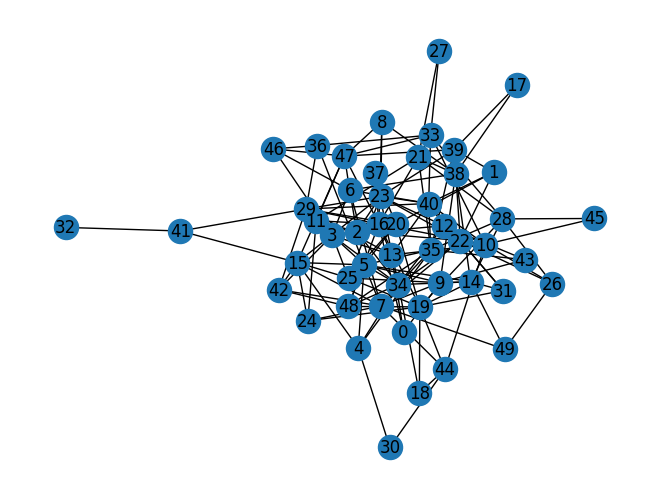

In [10]:
import networkx as nx

NUMBER_OF_NODES = 50
NUMBER_OF_EDGES = 150
SEED = 13

G = nx.generators.dense_gnm_random_graph(NUMBER_OF_NODES, NUMBER_OF_EDGES, seed=SEED)

nx.draw(G,with_labels=True)

## 2. Generate a neural network to solve your graph's MIS

### Perform an optimization using the structure and weights to determine the MIS

P Desired [-1250.]


/home/cledenmat/Documents/Master's Research/datalessMISNotebook/.venv/lib64/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training_step = 0 --- value = 283.6560 --- desired value set for optimization = -1250.0
training_step = 1 --- value = 252.4514 --- desired value set for optimization = -1250.0
training_step = 2 --- value = 226.2105 --- desired value set for optimization = -1250.0
training_step = 3 --- value = 201.1142 --- desired value set for optimization = -1250.0
training_step = 4 --- value = 176.0941 --- desired value set for optimization = -1250.0
training_step = 5 --- value = 152.8114 --- desired value set for optimization = -1250.0
training_step = 6 --- value = 131.2458 --- desired value set for optimization = -1250.0
training_step = 7 --- value = 113.0531 --- desired value set for optimization = -1250.0
training_step = 8 --- value = 98.7716 --- desired value set for optimization = -1250.0
training_step = 9 --- value = 85.5170 --- desired value set for optimization = -1250.0
training_step = 10 --- value = 72.5834 --- desired value set for optimization = -1250.0
training_step = 11 --- value = 60.

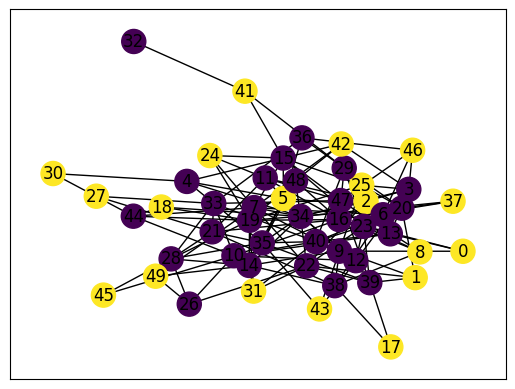

In [11]:
import torch
import numpy
import time
from datalessNN import datalessNN_graph_params, datalessNN_module
from layer_constraints import ZeroOneClamp

initial_learning_rate = 0.01
training_steps = 3500

## generate graph weights
NN_graph_params = datalessNN_graph_params(G)

graph_order = len(G.nodes)

NN = datalessNN_module(
    NN_graph_params["theta_tensor"],
    NN_graph_params["layer_2_weights"],
    NN_graph_params["layer_2_biases"],
    NN_graph_params["layer_3_weights"])

################# optimization
# good and fast results on most is found at initial_learning_rate = 0.001
optimizer = torch.optim.Adam(NN.parameters(), lr=initial_learning_rate)
loss_fn = torch.nn.MSELoss()

theta_constraint = ZeroOneClamp()

##################################################################################################
##################################################################################################
##################################################################################################

batch_size_gen = 1
batch_size_2 = batch_size_gen

################################################################
##### X_train is the same for both gen and combined models #####
################################################################

X_train = numpy.ones(len(NN_graph_params["theta_tensor"]))

############################################################
### Y_train_combined is the v_d (desired value)
################################################################

P_desired = numpy.zeros(1)
P_desired[0] = -graph_order**2 / 2

print("P Desired", P_desired)

Y_train_combined = numpy.zeros(shape=(batch_size_2, 1, 1))

Y_val_combined = P_desired.reshape(1, 1)
for i in range(batch_size_2):
    Y_train_combined[i, :, :] = Y_val_combined

Y_train_combined = Y_train_combined.reshape(batch_size_2, 1)

Y_desired = torch.Tensor(Y_val_combined)
Y_val_combined = Y_val_combined.reshape(1, 1, 1)
Y_val_combined = Y_val_combined.reshape(1, 1)
# Y_val_combined = Y_val_combined.reshape(3)

################################################################
### train
################################################################
X_star = None

start = time.time()
for i in range(training_steps):
    predicted_y = NN(X_train)

    loss = loss_fn(predicted_y, Y_desired)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## normalize theta values between 0 and 1
    NN[0].apply(theta_constraint)

    X_star = NN[0].weight

    if any(X_star > 1.0) or any(X_star < 0.0):
        print(f"exit AT training step = {i} --- THERE IS A A VALUE IN THE WEIGHTS OUTSIDE [0,1] --- x_star = {X_star}")
        break

    print(f"training_step = {i} --- value = {predicted_y.item():.4f} --- desired value set for optimization = {P_desired[0]}")

x_star = X_star.detach().numpy()

greater_than_09 = (x_star > 0.9).sum()
print(f"Size of MIS (theta > 0.9): {greater_than_09}")
nx.draw_networkx(G, node_color=x_star)